In [2]:
# Datasets: https://keras.io/api/datasets/
# Models: https://keras.io/api/applications/

# Base
#%matplotlib widget
import collections
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import skimage
import os
import sys
import random
import pandas as pd 

# Keras, Classification, Audio, Features
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.models import Model

# Preprocessing, Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Parameters
n_classes = 43
save_file_name = "weights_traffic.h5"

In [5]:
# Traffic signs

# Podatkovna zbirka: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
# German Traffic Sign Recognition Benchmark
# - More than 40 classes
# - More than 50,000 images in total

# Traffic sign classes from folder names
sign_index = os.listdir("TRAFFIC/Train")[:n_classes]

# Train dataset
data_images = []
data_labels = []

# Get images from folders - folder name is the class label 
for i_f in range(0, n_classes):
    dir = os.path.join('TRAFFIC', 'Train', str(i_f))

    # Load class images
    for i_i in os.listdir(dir):
        data_images.append(np.array(skimage.transform.resize(skimage.io.imread(os.path.join(dir, i_i)), (30, 30))))
        data_labels.append(i_f)

# Test dataset
csv_test = pd.read_csv('TRAFFIC/Test.csv')

csv_labels = csv_test["ClassId"].values
csv_imgs = csv_test["Path"].values

test_images = []
test_labels = []

# Load images
for i_i in range(0, len(csv_labels)):
    test_images.append(np.array(skimage.transform.resize(skimage.io.imread(os.path.join('TRAFFIC', csv_imgs[i_i])), (30, 30))))
    test_labels.append(csv_labels[i_i])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

data_images = np.array(data_images)
data_labels = np.array(data_labels)

# Spliting into train and validation
train_images, valid_images, train_labels, valid_labels = train_test_split(data_images, data_labels, test_size=0.2, stratify=data_labels)

In [6]:
# Check sizes
print(f"Data train: {np.shape(train_images)}\t labels: {len(train_labels)}")
print(f"Data valid: {np.shape(valid_images)}\t labels: {len(valid_labels)}")
print(f"Data test:  {np.shape(test_images)}\t labels: {len(test_labels)}")

Data train: (31367, 30, 30, 3)	 labels: 31367
Data valid: (7842, 30, 30, 3)	 labels: 7842
Data test:  (12630, 30, 30, 3)	 labels: 12630


In [7]:
# Basic image info
print(f"Dims:      {train_images[0].shape}")
print(f"Width:     {train_images[0].shape[1]}")
print(f"Height:    {train_images[0].shape[0]}")
print(f"Channels:  {train_images[0].shape[2]}")
print(f"Data type: {train_images[0].dtype}")
print(f"Samples:   {train_images[0][0, 0:5, 0]}")

Dims:      (30, 30, 3)
Width:     30
Height:    30
Channels:  3
Data type: float64
Samples:   [0.27295745 0.27137577 0.27351605 0.25492778 0.24418891]


Num. of imgs per class: 729.4651162790698 +- 550.2 [168 - 1800]


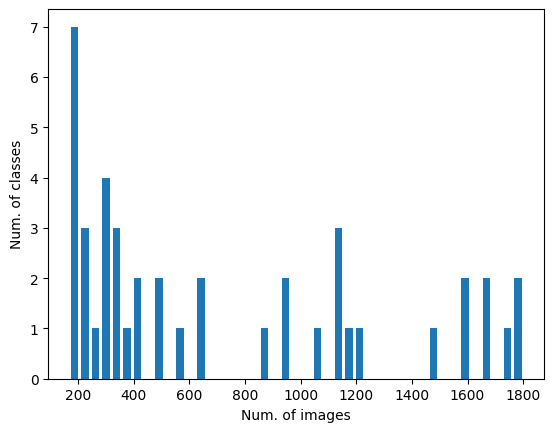

In [8]:
# Plot histogram of the distribution of the number of images per class in TRAIN data
img_per_class = list(collections.Counter(train_labels).values())

print(f"Num. of imgs per class: {np.mean(img_per_class)} +- {np.std(img_per_class) :.1f} [{np.min(img_per_class)} - {np.max(img_per_class)}]")

plt.figure()
plt.hist(img_per_class, bins=n_classes, rwidth=0.7)
plt.xlabel("Num. of images")
plt.ylabel("Num. of classes")
plt.show()

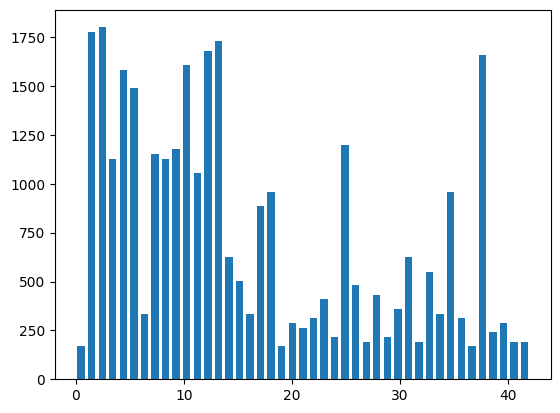

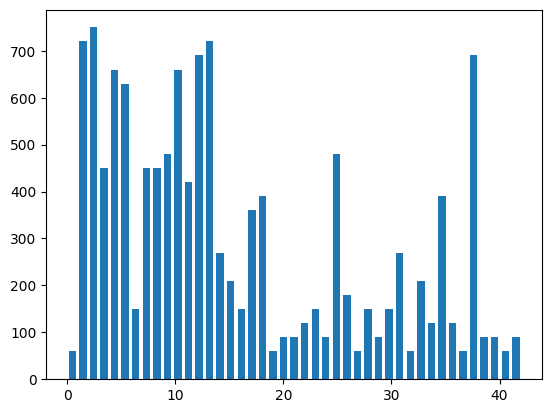

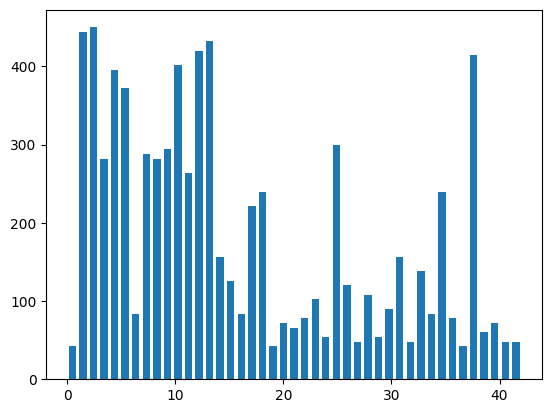

In [9]:
# Histograms of samples per class
plt.figure()
plt.hist(train_labels, bins=n_classes, rwidth=0.7)
plt.show()
plt.figure()
plt.hist(test_labels, bins=n_classes, rwidth=0.7)
plt.show()
plt.figure()
plt.hist(valid_labels, bins=n_classes, rwidth=0.7)
plt.show()

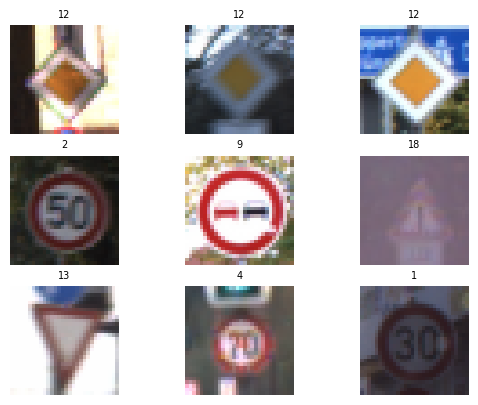

In [10]:
# Plot some random images from TRAIN dataset
rows = 3
cols = 3
fig, axs = plt.subplots(rows, cols)

for r in range(0, rows):
    for c in range(0, cols):
        i = random.randint(0, np.shape(train_images)[0])
        axs[r, c].axis("off")
        axs[r, c].set_title(train_labels[i], fontsize=7)
        axs[r, c].imshow(train_images[i])

plt.show()

In [11]:
# Scaling
n_color_channels = 3

for i_c in range(n_color_channels):
    scaler = StandardScaler()
    # Train
    img_chan = train_images[:, :, :, i_c].reshape(np.shape(train_images)[0], np.shape(train_images)[1]*np.shape(train_images)[2])
    img_chan_scaled = scaler.fit_transform(img_chan).reshape(np.shape(train_images)[0], np.shape(train_images)[1], np.shape(train_images)[2])
    train_images[:, :, :, i_c] = img_chan_scaled

    # Valid
    img_chan = valid_images[:, :, :, i_c].reshape(np.shape(valid_images)[0], np.shape(valid_images)[1]*np.shape(valid_images)[2])
    img_chan_scaled = scaler.fit_transform(img_chan).reshape(np.shape(valid_images)[0], np.shape(valid_images)[1], np.shape(valid_images)[2])
    valid_images[:, :, :, i_c] = img_chan_scaled

    # Test
    img_chan = test_images[:, :, :, i_c].reshape(np.shape(test_images)[0], np.shape(test_images)[1]*np.shape(test_images)[2])
    img_chan_scaled = scaler.fit_transform(img_chan).reshape(np.shape(test_images)[0], np.shape(test_images)[1], np.shape(test_images)[2])
    test_images[:, :, :, i_c] = img_chan_scaled

In [12]:
# NN model
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=train_images.shape[1:]))
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(n_classes))

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions
metr = keras.metrics.SparseCategoricalAccuracy() # Calculates how often predictions match integer labels
model.compile(optimizer=opt, loss=loss, metrics=metr)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [14]:
# Stopping criterion to avoid overfitting
# patience: Number of epochs with no improvement after which training will be stopped.
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Save best weights
model_checkpoint = ModelCheckpoint(save_file_name, save_best_only=True, save_weights_only=True)

# Train
t_epochs = 50
b_size = 32
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=t_epochs, batch_size=b_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
981/981 [==============================] - 38s 38ms/step - loss: 1.1084 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.1709 - val_sparse_categorical_accuracy: 0.9579
Epoch 2/50
981/981 [==============================] - 38s 38ms/step - loss: 0.2552 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.0819 - val_sparse_categorical_accuracy: 0.9788
Epoch 3/50
981/981 [==============================] - 37s 37ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.0619 - val_sparse_categorical_accuracy: 0.9865
Epoch 4/50
981/981 [==============================] - 36s 37ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.9575 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9911
Epoch 5/50
981/981 [==============================] - 36s 37ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.0320 - val_sparse_categorical_accuracy: 0.9926
Epoch 6/50
981/981 [==============================] - 36s 37ms/step - loss: 0.1217 - spars

In [15]:
# Load best weights
model.load_weights(save_file_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


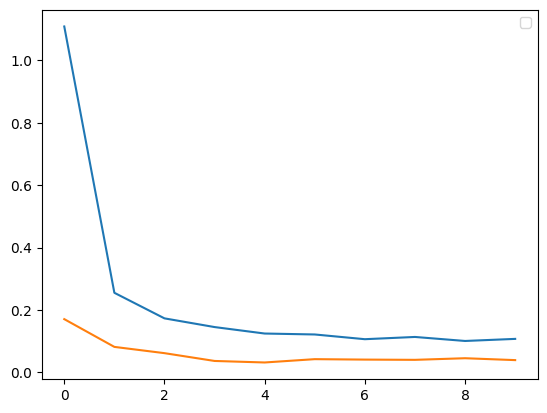

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


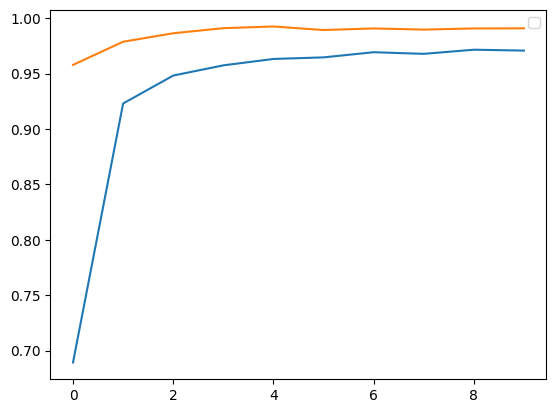

In [16]:
# Lets observe the loss metric on both the training (blue) and validation (orange) set
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend()
plt.show()

In [17]:
# Now to evaluate our model on train and test data

# Train
test_loss, test_acc = model.evaluate(train_images, train_labels, verbose=0)
print('Acc train: %.3f' % test_acc)

# Test
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Acc test: %.3f' % test_acc)

Acc train: 0.995
Acc test: 0.957


395/395 [==============================] - 3s 8ms/step


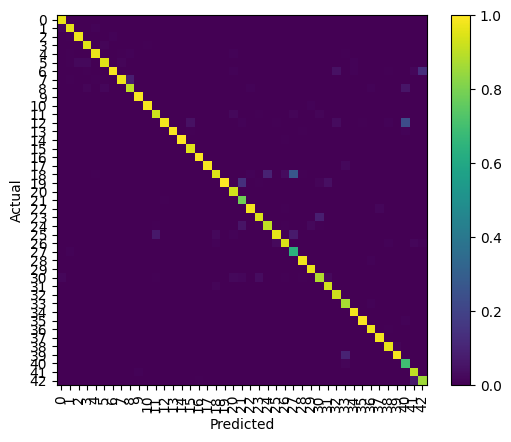

In [18]:
# Test NN
# Predictions for additional analysis
predictions = model.predict(test_images)

# Confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")

# Visualise confusion matrix
plt.figure()
plt.imshow(conf)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.yticks(np.arange(n_classes), range(0, n_classes))
plt.xticks(np.arange(n_classes), range(0, n_classes), rotation='vertical')
plt.colorbar()
plt.show()

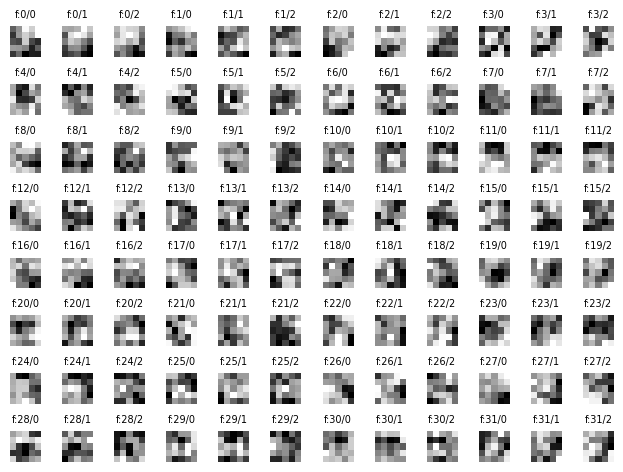

In [19]:
# Check the filters on first Conv2D layer
i_layer = 0

sub_model = Model(inputs=model.inputs , outputs=model.layers[i_layer].output)

# Retrieve weights
filters, bias = model.layers[i_layer].get_weights()

# Normalize filter
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot filter
rows = 8
cols = 4*3
fig, axs = plt.subplots(rows, cols)

f_i = 0
for r in range(0, rows):
    for c in range(0, cols, 3):
        # Filters (Width, Height, Channels)
        f = filters[:,:,:,f_i]

        # Filters for three Channels
        for f_j in range(0, 3):
            axs[r, c+f_j].axis("off")
            axs[r, c+f_j].set_title(f"f:{f_i}/{f_j}", fontsize=7)
            axs[r, c+f_j].imshow(f[:,:,f_j], cmap='gray')

        f_i = f_i + 1

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 30ms/step


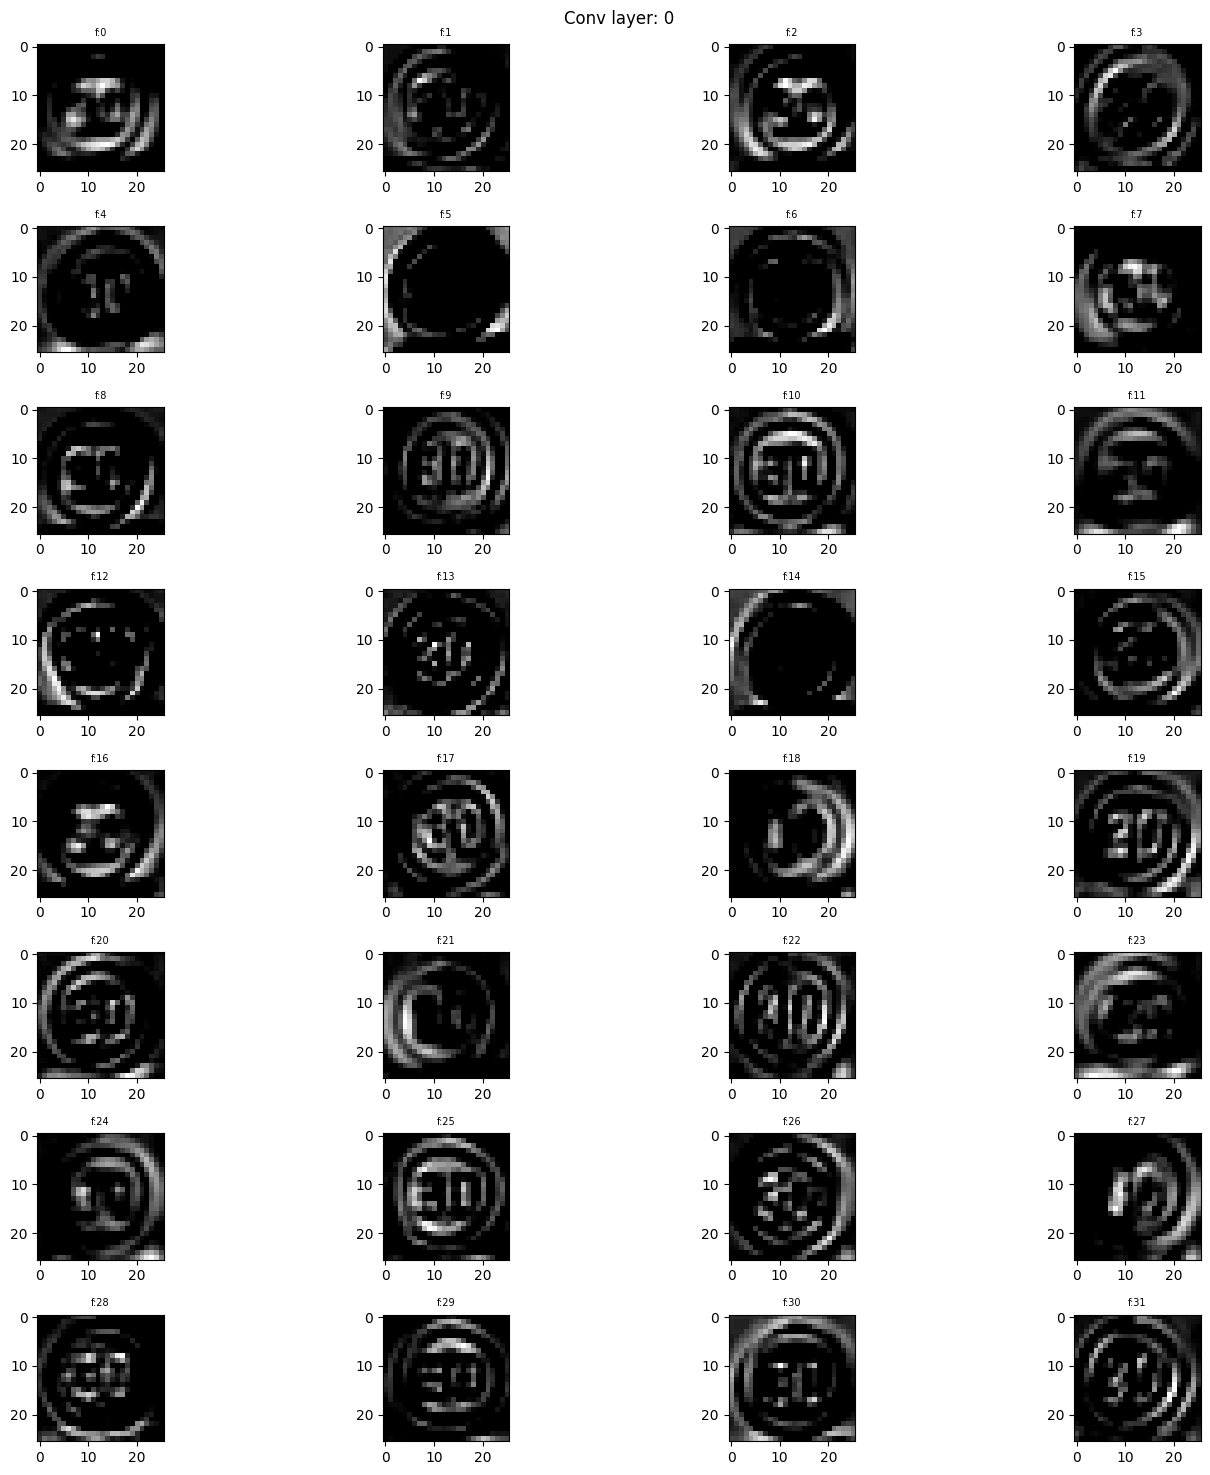

1/1 [==============================] - 0s 36ms/step


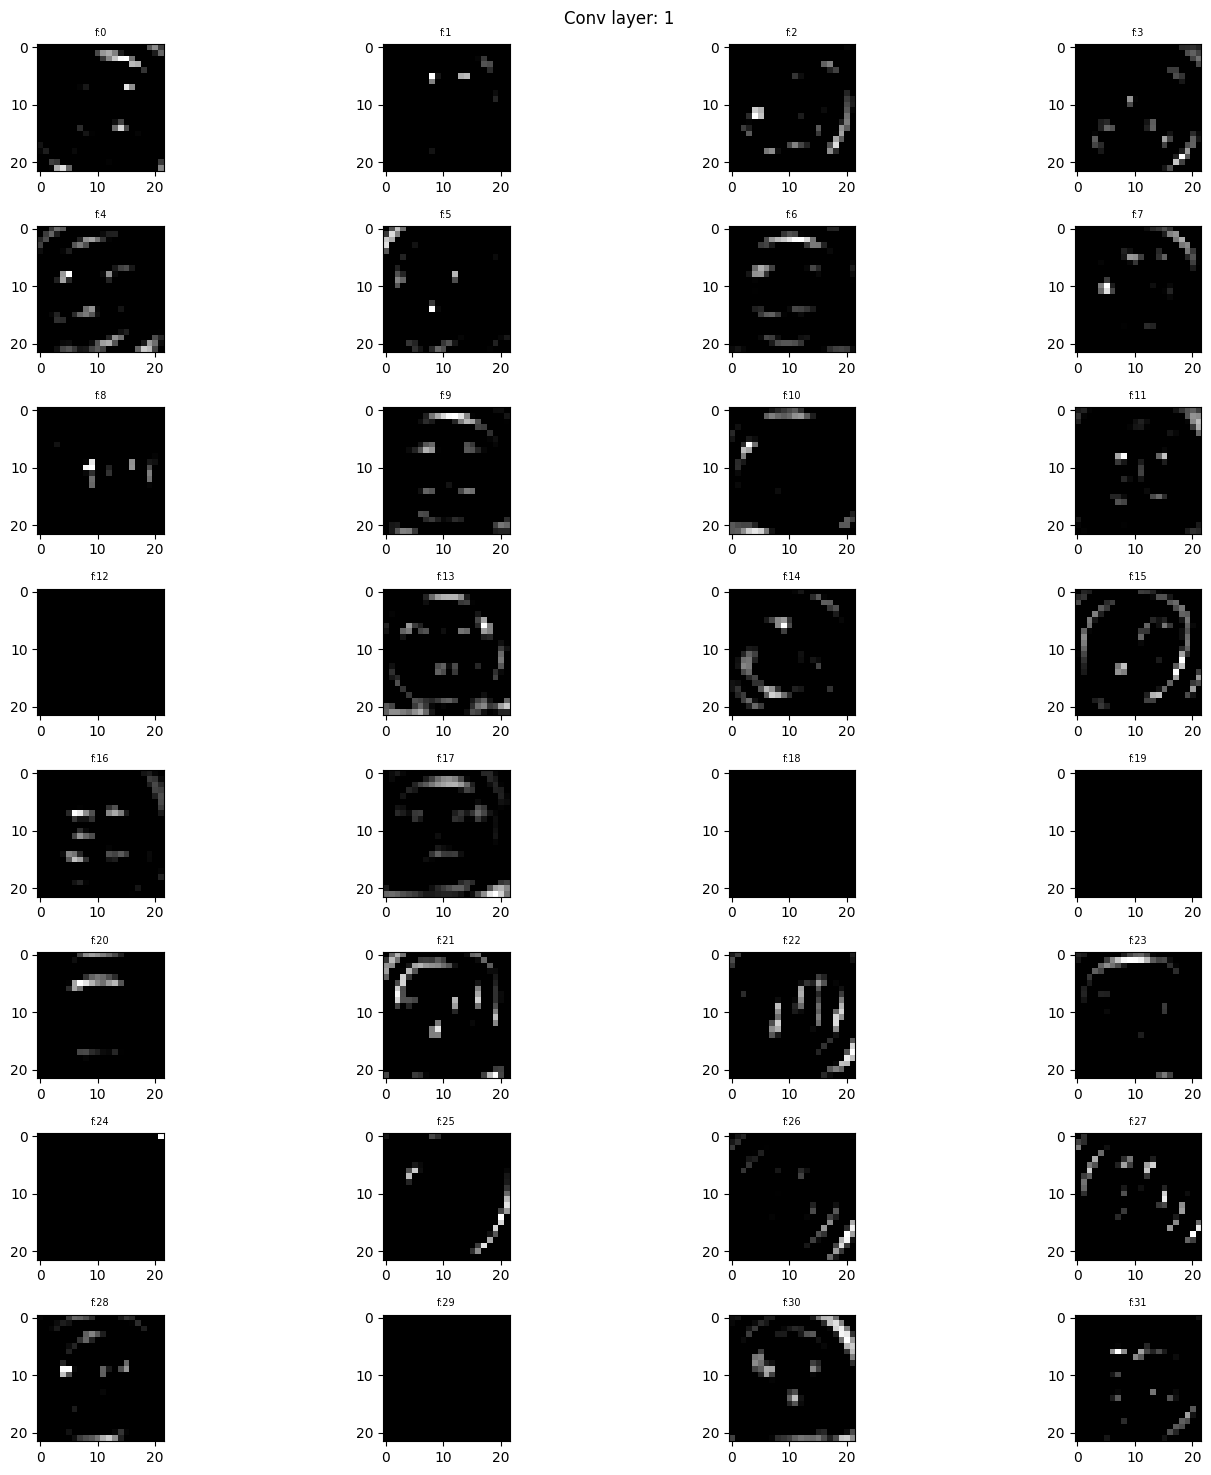

1/1 [==============================] - 0s 44ms/step


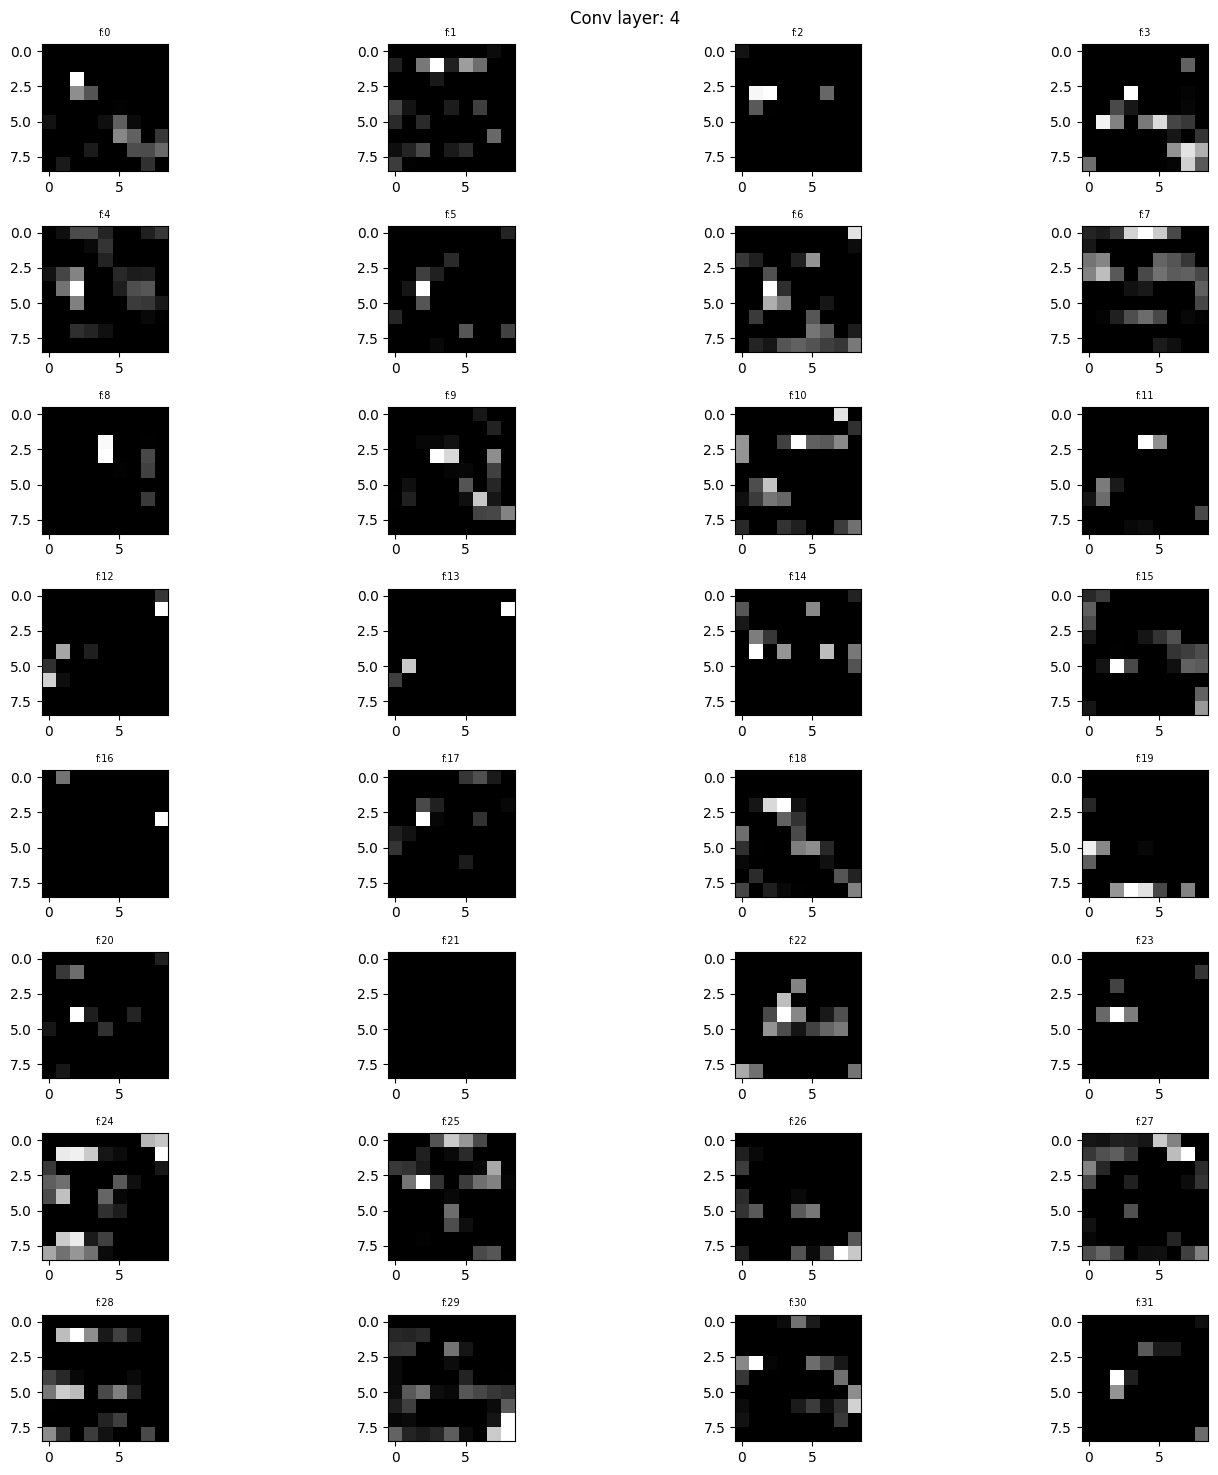

1/1 [==============================] - 0s 48ms/step


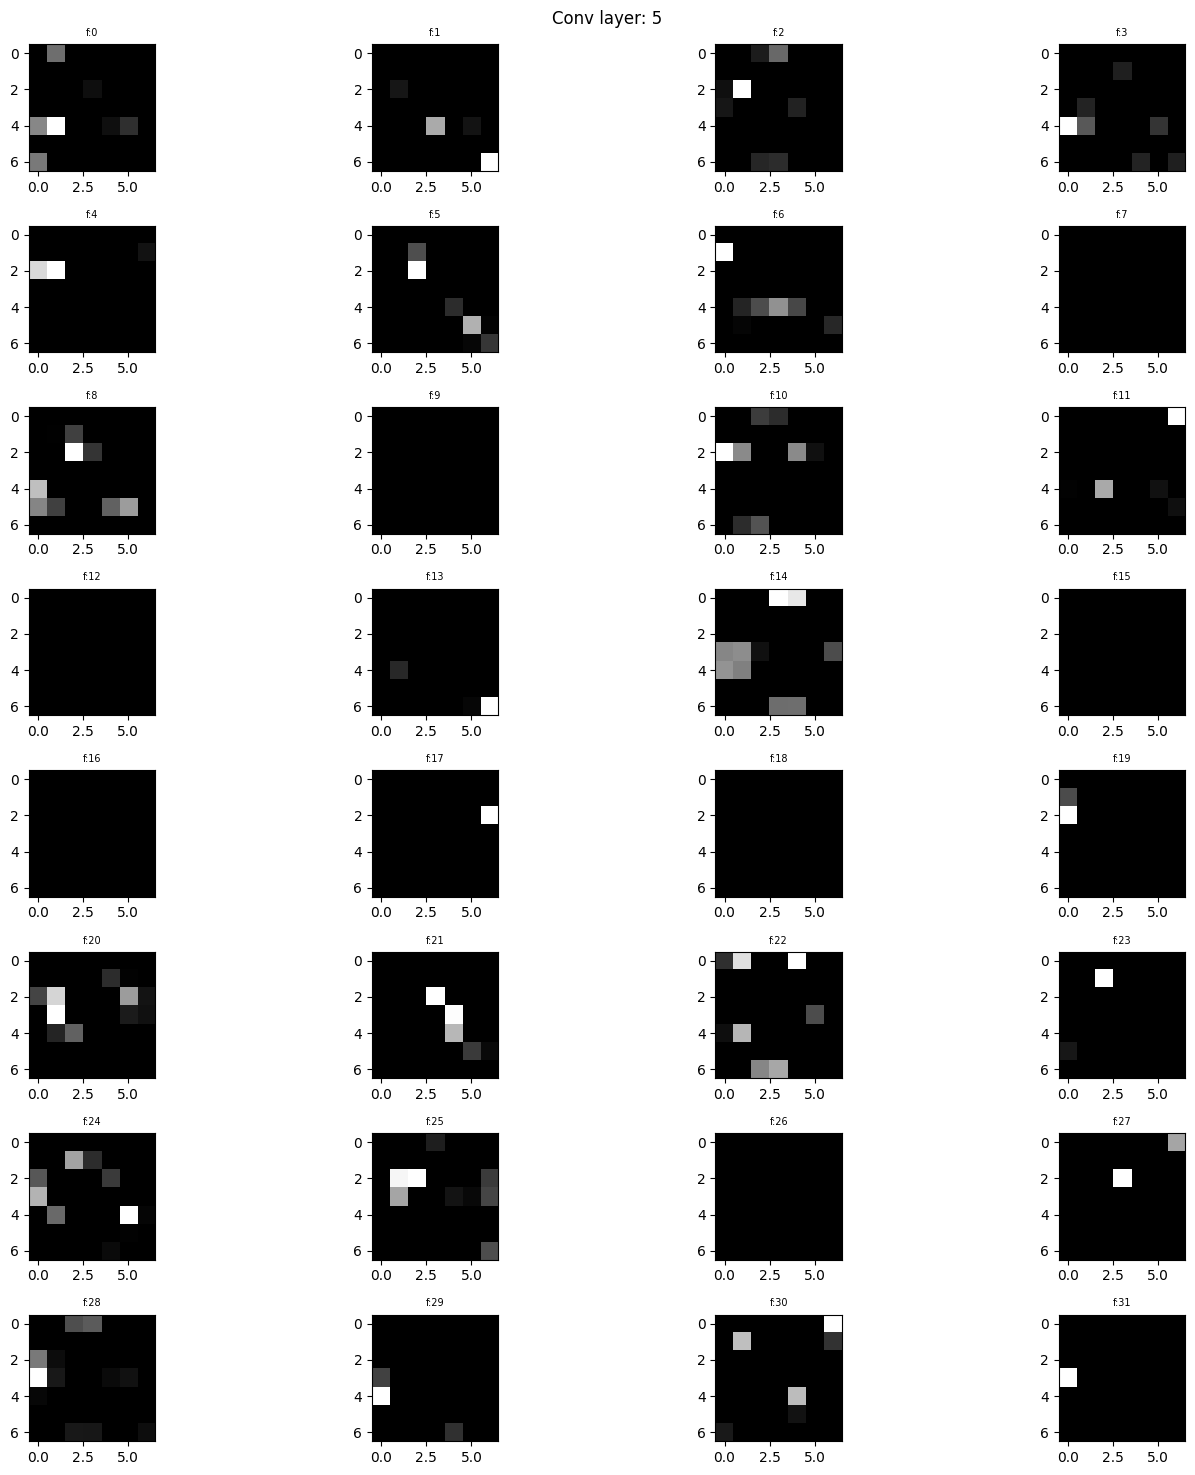

1/1 [==============================] - 0s 49ms/step


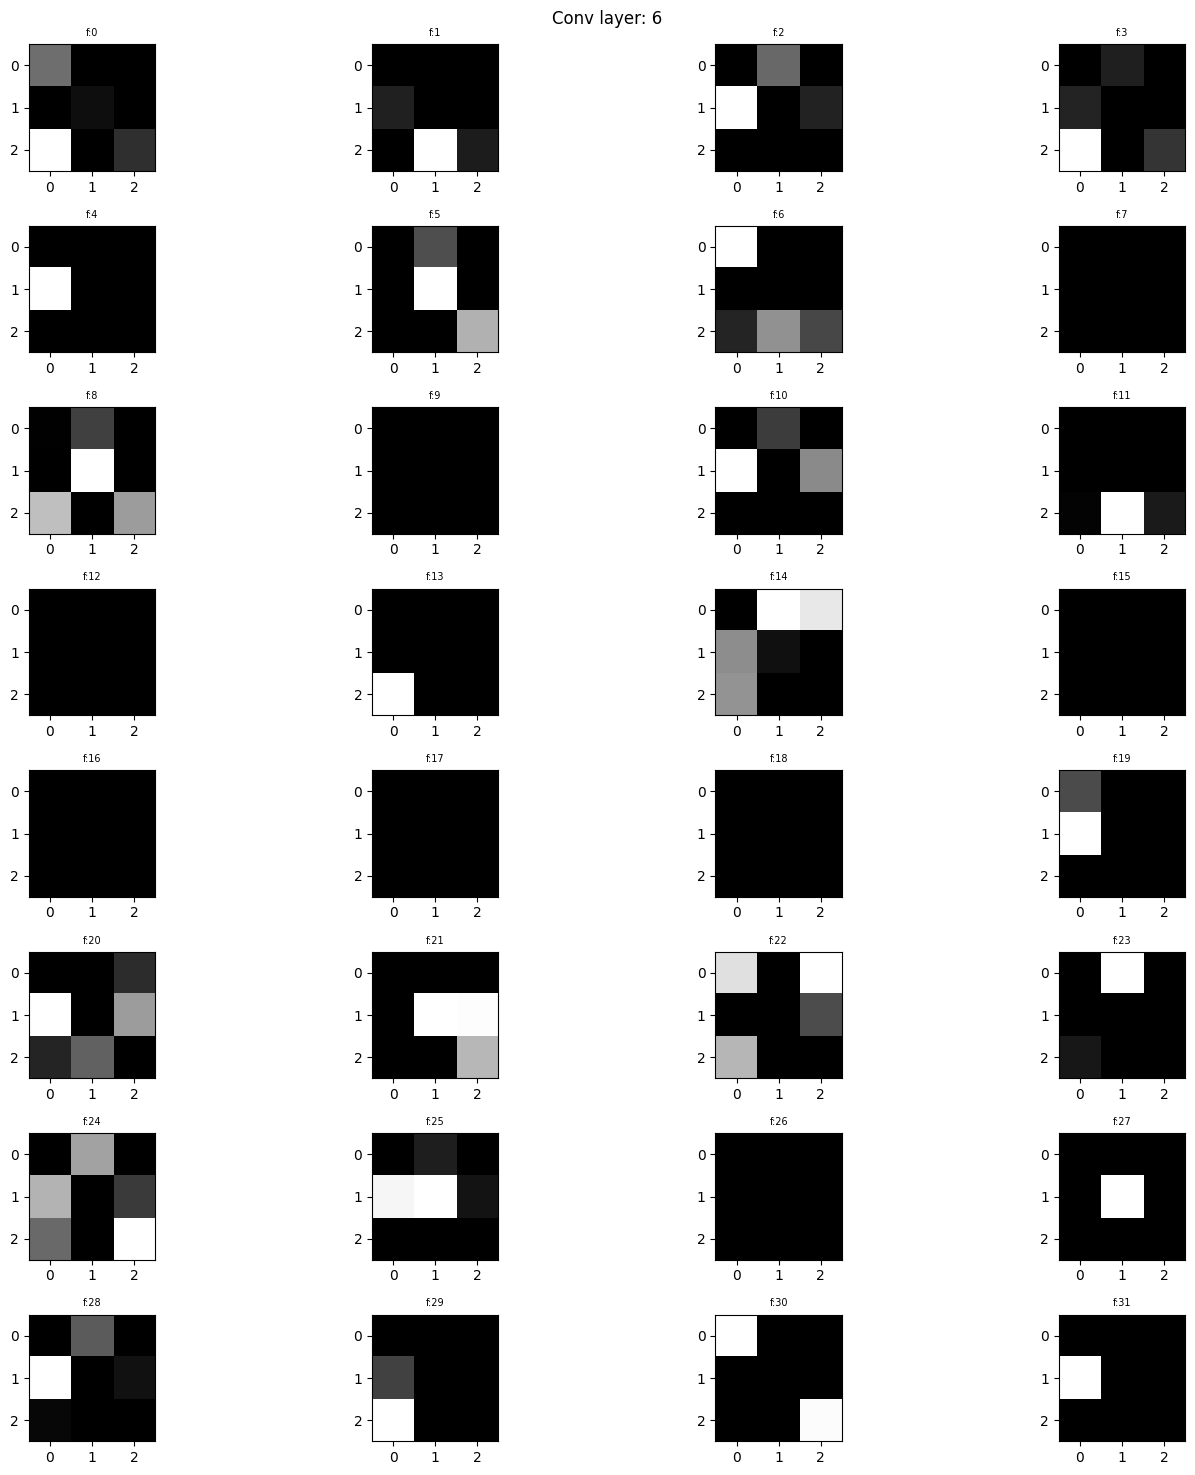

In [20]:
# Check how images look after filter application

def plot_filtered(i_layer, img):
    # Load layer
    sub_model = Model(inputs=model.inputs, outputs=model.layers[i_layer].output)

    # Use NN
    features = sub_model.predict(img.reshape(-1, np.shape(img)[0], np.shape(img)[1], np.shape(img)[2]))

    # Plot filtered images
    rows = 8
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle(f'Conv layer: {i_layer}', fontsize=12)

    f_i = 0
    for r in range(0, rows):
        for c in range(0, cols):
            # Filtered image
            img = features[:,:,:,f_i]

            axs[r, c].set_title(f"f:{f_i}", fontsize=7)
            axs[r, c].imshow(img[0], cmap='gray')

            f_i = f_i + 1

    plt.tight_layout()
    plt.show()

# Choose random image from TRAIN dataset
i_img = random.randint(0, np.shape(train_images)[0])
img = train_images[i_img]

# Filtered images
for i in [0, 1, 4, 5, 6]:
    plot_filtered(i, img)

In [ ]:
# Running with GPU and WSL2

# wget https://developer.download.nvidia.com/compute/cuda/repos/wsl-ubuntu/x86_64/cuda-wsl-ubuntu.pin
# sudo mv cuda-wsl-ubuntu.pin /etc/apt/preferences.d/cuda-repository-pin-600
# wget https://developer.download.nvidia.com/compute/cuda/12.1.1/local_installers/cuda-repo-wsl-ubuntu-12-1-local_12.1.1-1_amd64.deb
# sudo dpkg -i cuda-repo-wsl-ubuntu-12-1-local_12.1.1-1_amd64.deb
# sudo cp /var/cuda-repo-wsl-ubuntu-12-1-local/cuda-*-keyring.gpg /usr/share/keyrings/
# sudo apt-get update
# sudo apt-get -y install cuda
# pip install nvidia-cudnn-cu12

# Set
# CUDNN_PATH=$(dirname $(python3 -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CUDNN_PATH/lib

# Test if GPU works
# python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
# python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

# Convert .ipynb to python script and run it
# python3 -m jupyter nbconvert --to python nn_image_classification.ipynb
# python3 nn_image_classification.py